In [120]:
import pandas as pd
import os
import time
import numpy as np
import pandas as pd
#from sklearnex import patch_sklearn #use intel patch before importing sklearn
#patch_sklearn()
from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn import linear_model, svm, tree, ensemble, neighbors
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

from xgboost import XGBRegressor
import lightgbm as lgbm

In [65]:
#%cd ./network_sniff/
#%ls

2411_donation_pool_XMR.pcapng
2911_traffic_calme.csv
2911_traffic_calme.pcapng
2911_traffic_calme_consultation de_site_cloud_arrière_plan
traffic calme internet lancement minage.pcapng
traffic_minage_1811_15.csv
traffic_minage_1811_15.pcapng


# 0) Create reporting 

In [121]:
def model_cv_rapport(model , name  : str, x : np.array, y : np.array, cv=5, precision = 8):
    """
    Apply the model then cross validate and export its score 
    """
    #making sure data is standarized
    pipe = Pipeline([
        ('scale', preprocessing.StandardScaler()),
        ('clf', model)
    ])
    score = cross_validate(pipe, x, y, cv=cv,
                           scoring=["precision", "recall", "f1", "roc_auc", "accuracy"],
                           verbose=10,
                           n_jobs=-1)
    print (name, "--------------------------------------")
    print("Precision: ", round(score["test_precision"].mean(), precision))
    print("Recall: ", round(score["test_recall"].mean(), precision))
    print("F1: ", round(score["test_f1"].mean(), precision))
    print("ROC: ", round(score["test_roc_auc"].mean(), precision))
    print("Accuracy: ", round(score["test_accuracy"].mean(), precision))

# 1) Import the dataset

As https://doi.org/10.1016/j.comcom.2021.02.016 and promizing : http://doi.acm.org/10.1145/3243734.3243858


In [61]:
df_mining = pd.read_csv("traffic_minage_1811_15.csv", index_col= 0)
df_not_mining = pd.read_csv("2911_traffic_calme.csv", index_col= 0)

In [60]:
df_mining.groupby('Destination').count()


,Time,Source,Protocol,Length,Info
Destination,,,,,
10.29.231.206,37,37,37,37,37
178.128.242.134,6,6,6,6,6
192.44.75.10,2,2,2,2,2
199.247.27.41,1,1,1,1,1
23.200.86.233,8,8,8,8,8
23.200.87.12,6,6,6,6,6
34.120.208.123,2,2,2,2,2
34.160.144.191,2,2,2,2,2
34.98.75.36,2,2,2,2,2


We define all traffic trom the mining dataset as comming from the miner and all the one from the other dataset as not mining

In [72]:
df_mining['miner'] = True
df_not_mining['miner'] = False

Compute time difference between two packages

In [70]:
df_mining['delta'] = df_mining.Time.diff()
df_not_mining['delta'] = df_not_mining.Time.diff()

In [95]:
df_ML = pd.concat([df_mining, df_not_mining])
df_ML.reset_index(inplace = True)
df_ML.drop(['Time', 'Source', 'No.', 'Destination', 'Protocol', 'Info'], axis = 1, inplace = True)

In [133]:
df_ML.describe()
df_ML.dropna(inplace = True)
df_ML.columns

Index(['Length', 'delta', 'miner'], dtype='object')

In [134]:
df_ML.groupby('miner').mean()

,Length,delta
miner,,
False,755.159375,0.030100
True,89.083333,0.726751


array([[<AxesSubplot:title={'center':'Length'}>,
        <AxesSubplot:title={'center':'delta'}>]], dtype=object)

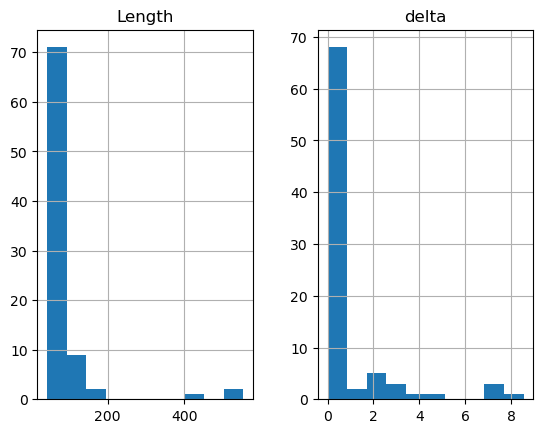

In [119]:
df_ML.loc[df_ML['miner'] == True].hist()

array([[<AxesSubplot:title={'center':'Length'}>,
        <AxesSubplot:title={'center':'delta'}>]], dtype=object)

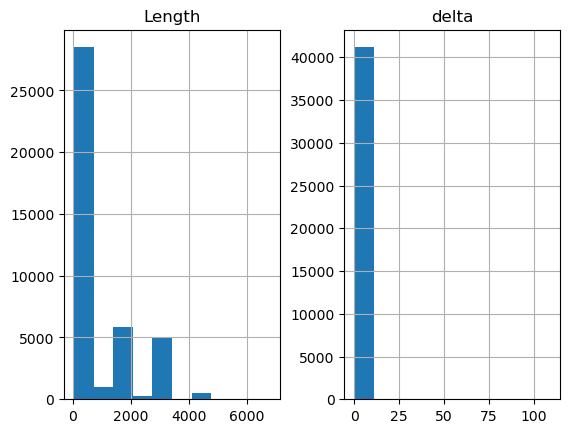

In [118]:
df_ML.loc[df_ML['miner'] == False].hist()

In [135]:
y = df_ML['miner']
x = df_ML.drop('miner', axis = 1)

In [147]:
y.describe

<bound method NDFrame.describe of 1         True
2         True
3         True
4         True
5         True
         ...  
41267    False
41268    False
41269    False
41270    False
41271    False
Name: miner, Length: 41270, dtype: bool>

In [151]:
y.value_counts()

False    41186
True        84
Name: miner, dtype: int64

# ML Algorithm

In [136]:
#Setting model
model = svm.SVC(kernel="rbf", gamma="scale")

In [137]:
model_cv_rapport(model, "Non tuned SVC", x, y)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................


/Users/albertdulout/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/albertdulout/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/albertdulout/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/albertdulout/opt/anaconda3/lib/python3.9/site-packages

[CV] END  accuracy: (test=0.998) f1: (test=0.000) precision: (test=0.000) recall: (test=0.000) roc_auc: (test=0.701) total time=   6.4s
[CV] END  accuracy: (test=0.998) f1: (test=0.000) precision: (test=0.000) recall: (test=0.000) roc_auc: (test=0.758) total time=   6.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    6.5s remaining:    9.8s


[CV] END  accuracy: (test=0.998) f1: (test=0.000) precision: (test=0.000) recall: (test=0.000) roc_auc: (test=0.637) total time=   6.6s


[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:    6.7s remaining:    4.5s


[CV] END  accuracy: (test=0.998) f1: (test=0.000) precision: (test=0.000) recall: (test=0.000) roc_auc: (test=0.748) total time=   6.9s


/Users/albertdulout/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END  accuracy: (test=0.998) f1: (test=0.000) precision: (test=0.000) recall: (test=0.000) roc_auc: (test=0.479) total time=   4.1s
Non tuned SVC --------------------------------------
Precision:  0.0
Recall:  0.0
F1:  0.0
ROC:  0.66472425
Accuracy:  0.99796462


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   10.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   10.6s finished
